# Transmission matrix 
## acquisition, calculation and phase conjugation

#### import libraries

In [1]:
from slmOptim.optimization import transmission_matrix
from slmOptim.zeluxPy import helper_functions as cam
from slmOptim.patternSLM import patterns as pt
from slmOptim.patternSLM.helper_functions import check, plot_focus

from slmPy import slmpy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pickle

#### set experiment parameters

In [2]:
# SLM-hadamard parameters
# the order of hadamard matrix -> 2^order x 2^order hadamard matrix dimensions
order = 4
# define macropixels on slm -> increases dimension by 2^(mag-1)
mag = 4

# Define observation window on camera
# just be careful on the -3 factor, it comes from the camera
middle_x = int(1440 / 2)
middle_y = int(1080 / 2)
dim = 100
roi = (middle_x - dim, middle_y - dim, middle_x + dim - 3, middle_y + dim - 3)

# Define camera macropixel, this is defined by the measured speckel grain
speckele_grain = 4
bins = speckele_grain

# Define camera acquisition parameters
exposure_time = 100
gain = 1
timeout= 100 

# Correction pattern path
path = '/home/optomeca/Dropbox/optomecAI/Py/SLM/deformation_correction_pattern/CAL_LSH0701789_633nm.bmp'

#### just do some quick checks

/home/optomeca/Projects/slmPy/slmpy/slmpy.py:86: wxPyDeprecationWarning: Using deprecated class. Use Cursor instead.
  cursor = wx.StockCursor(wx.CURSOR_BLANK)


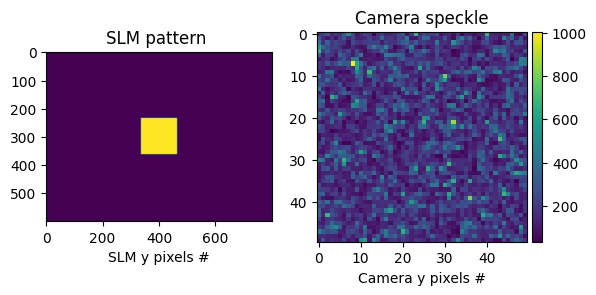

In [3]:
pattern, frame = check((0, 0), order, mag, roi, bins, exposure_time, gain, timeout)

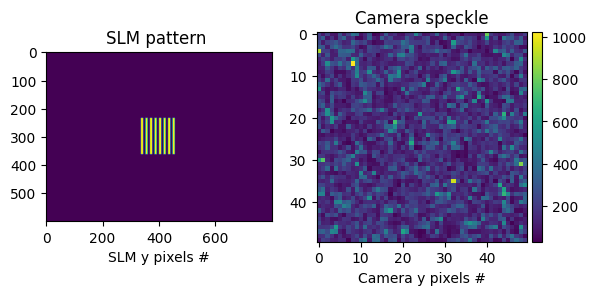

In [4]:
pattern, frame = check((0, 1), order, mag, roi, bins, exposure_time, gain, timeout)

### 1. Perform TM measurement

In [23]:
tm_raw = transmission_matrix.measTM(roi=roi, 
                            bins=bins, 
                            exposure_time=exposure_time, 
                            order=order, 
                            mag=mag, 
                            path=None)

patterns, frames = tm_raw.get_tm()

#save measurement to file
tm_raw.save_tm()

/home/optomeca/Projects/slmPy/slmpy/slmpy.py:86: wxPyDeprecationWarning: Using deprecated class. Use Cursor instead.
  cursor = wx.StockCursor(wx.CURSOR_BLANK)


Uploading Hadamard patterns:   0%|          | 0/256 [00:00<?, ?it/s]

USB camera configured, armed and triggered.
Program execution completed.


### 2. Calculate TM

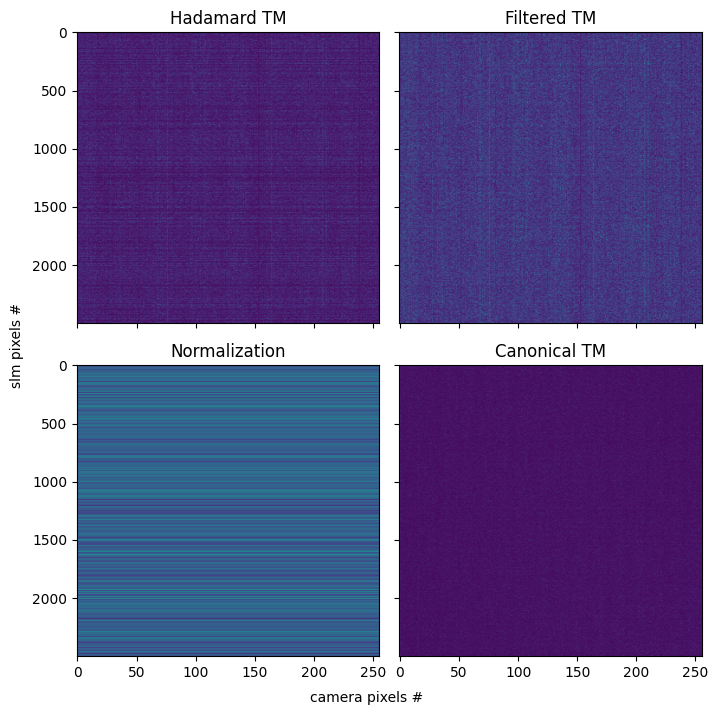

In [24]:
# open a file, where you stored the pickled data
with open('20230804-1837_tm_raw_data_ROI(620, 440, 817, 637)_Bins4_Order4_Mag4.pkl', 'rb') as fp:
    data = pickle.load(fp)

tr = transmission_matrix.calcTM(frames)
_, _, _, tm = tr.calc_plot_tm()

In [7]:
frame[1].shape

(50, 50)

### 3. Phase conjugation

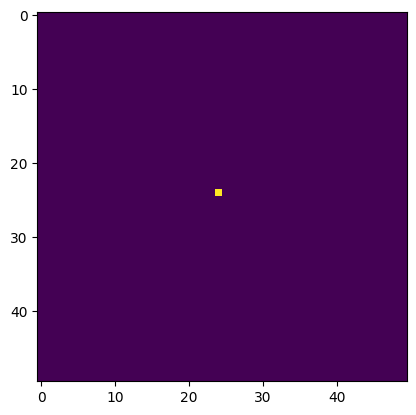

In [25]:
tgt = transmission_matrix.Target((50, 50))
target_frame = tgt.square((1, 1))

plt.imshow(target_frame)

msk = transmission_matrix.InverseLight(target_frame, tm, mag=4)
phase_mask = msk.inverse_prop()

### 4. Focusing

#### open slm

In [26]:
slm = slmpy.SLMdisplay(monitor=1)

#### merge calculated phase mask into an slm pattern

In [27]:
resX, resY = slm.getSize()
slm_patterns = pt.Pattern(resX, resY)
patternSLM = pt.Pattern(resX, resY)
focusing_mask = patternSLM.add_subpattern(phase_mask, gray = 10)

#### upload pattern to slm

In [28]:
slm.updateArray(focusing_mask)

#### get frame and plot

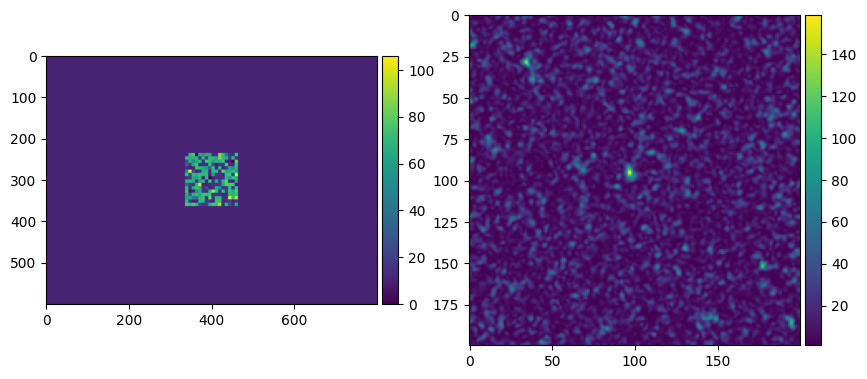

In [29]:
frame = cam.get_frame_binned(roi, 1, gain, exposure_time, gain, timeout)

plot_focus(focusing_mask, frame)

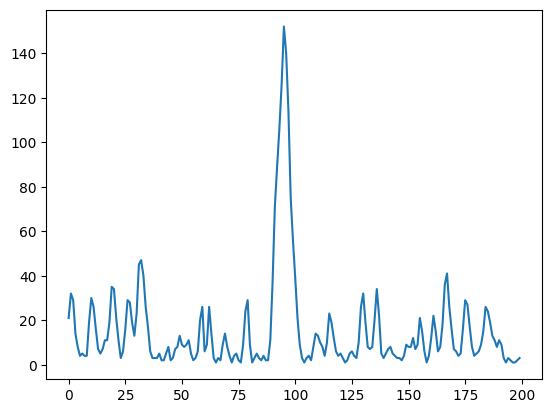

In [30]:
plt.plot(frame[1][:, 96])

#### close slm

In [14]:
slm.close()